In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize


### Estimation of $P_{nd_n}(V_{nt})$
We will start by estimation conditional probability of agent $n$ choosing 
sequence of choices $ d_n = (d_{n1}, \dots, d_{nT}) \in \{-1, 1\}^{T}$. 
Agent choose $d_n$ if 
$$d_{nt}U_{nt} = d_{nt}(\beta'_{n}x_{nt} +\eta_n + \varepsilon_{nt}) = d_{nt}(V_{nt} +\eta_n + \varepsilon_{nt})  > 0 \quad \forall t
$$
Since we will assume taste variation, it means that $\beta_n$ is random. For 
simplicity lets estimate conditional probability of agent $n$ choosing
sequence of action $d_{n}$ given both $\beta_n$ and $\eta_n$

We will estimate the following:
$$P(d_n |V_{n}) =\int_{\mathbb{R}}P(d_n |V_{n}, \eta_n) \phi(\eta_n)d\eta_n= \int_{\mathbb{R}}  \prod_{t=1}^{T}\Phi((V_{nt} + \eta_n)d_{nt}) \phi(\eta_n)d\eta_n$$
using trains procedure:


1. Take a draw from a normal density with zero mean and $ \sigma $ variance.
2. For this draw of $ \eta_n $, calculate $ H_{nd_n}(\eta_n) $ .
3. Repeat steps 1–2 many times, and average the results.
      This average is a simulated approximation to $ P_{nd_n} $ .



(array([1250.,  758.,  657.,  650.,  737.,  709.,  759.,  882., 1074.,
        2524.]),
 array([2.88186405e-11, 4.13827156e-02, 8.27654312e-02, 1.24148147e-01,
        1.65530862e-01, 2.06913578e-01, 2.48296294e-01, 2.89679009e-01,
        3.31061725e-01, 3.72444440e-01, 4.13827156e-01]),
 <BarContainer object of 10 artists>)

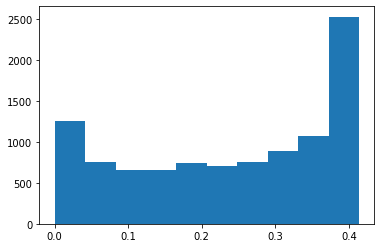

In [2]:
def H(eta, V_n, d_n):
    return np.prod(norm.cdf((V_n + eta) * d_n), axis=1)


# we will fix amount of periods for each agent `n`
T = 5
# sigma will be estimated with SMLE
sigma = 1
# V_n is a combination of betas, which will
# be estimated from SMLE and fixed data
V_n = np.array([-1, 0, 1, 2, 3])
# d_n is from fixed data (y = 1 or y = 0)
d_n = np.array([-1, -1, 1, 1, 1])

# number of simulations to estimate integral
simulation_size = 10_000
# step 1
simulated_etas = np.random.normal(
    loc=0,
    scale=sigma,  # important
    size=(simulation_size, 1)
)
# stack simulated normal r.v to perform broadcasting
simulated_etas = np.repeat(simulated_etas, 5, axis=1)
# step 2. obtain distribution of function values
result = H(simulated_etas, V_n, d_n)

plt.hist(result)


### Estimation of parameters

First of all we would like to derive from data estimations of the following parameters:
$\pmb\Sigma$, $\pmb{b}$, $\sigma$, given our data $x_n = (x_{n1}, \dots, x_{nT})$,
sequence of choices $d_n = (d_{n1}, \dots, d_{nT})$ and net utility structure 
$U_{nt} = \beta' x_{nt} + \eta_n + \varepsilon_{nt}$, where $\eta_n$ is iid 
across agents normal with zero-scalar mean and variance $\sigma$ and $\varepsilon_{nt}$
is iid across agents and time normal with zero-vector mean and $\pmb\Omega$ covariance
matrix with following form (from [probit\_panel.pdf](probit_panel.pdf)):
$$
\pmb\Omega =
 \begin{pmatrix*} 
1 + \sigma & \sigma& \dots & \sigma \\
\sigma & 1+\sigma& \dots & \sigma \\
\sigma & \sigma&\dots &1 + \sigma \\
\end{pmatrix*}
$$

$$
\begin{align*}
    P(d_n |x_n) & = \int_{\mathbb{R}^k} \left(\int_{\mathbb{R}}
    P(d_n |\eta, \beta, x_n) \phi_{\sigma}(\eta)d\eta \right)
    \phi_{\Sigma}(\beta)d\beta                              \\
                & =\int_{\mathbb{R}^k}\left(\int_{\mathbb{R}}
    \prod_{t=1}^{T}\Phi((\beta'x_{nt} + \eta)d_{nt})
    \phi_{\sigma}(\eta)d\eta \right)\phi_{\Sigma}(\beta)
    d\beta
\end{align*}
$$

Then MLE for every person would be the following:
$$
\begin{align*}
    P(d |x) & = \int_{\mathbb{R}^k} \left(\int_{\mathbb{R}}
    P(d |\eta, \beta, x) \phi_{\sigma}(\eta)d\eta \right)
    \phi_{\Sigma}(\beta)d\beta \\
   & = \int_{\mathbb{R}^k} \prod_{n=1}^N\left(\int_{\mathbb{R}}
    P(d_n |\eta, \beta, x_n) \phi_{\sigma}(\eta)d\eta \right)
    \phi_{\Sigma}(\beta)d\beta \\
    & = \int_{\mathbb{R}^k} \prod_{n=1}^N\left(\int_{\mathbb{R}} \prod_{t=1}^T
    P(d_{nt} |\eta, \beta, x_{nt}) \phi_{\sigma}(\eta)d\eta \right)
    \phi_{\Sigma}(\beta)d\beta 
                                 \\
                & =\int_{\mathbb{R}^k}\prod_{n=1}^N\left(\int_{\mathbb{R}}
    \prod_{t=1}^{T}\Phi((\beta'x_{nt} + \eta)d_{nt})
    \phi_{\sigma}(\eta)d\eta \right)\phi_{\Sigma}(\beta)
    d\beta
\end{align*}
$$

### Parameters

Then MLE for every person would be the following:
$$
                \int_{\mathbb{R}^k}\prod_{n=1}^N\left(\int_{\mathbb{R}}
    \prod_{t=1}^{T}\Phi((\beta'x_{nt} + \eta)d_{nt})
    \phi_{\sigma}(\eta)d\eta \right)\phi_{\Sigma}(\beta)
    d\beta
$$

In [14]:

def sample_from_multivariate_normal(n, beta, Sigma):

    L = np.linalg.cholesky(Sigma)
    # Sample X from standard normal
    X = np.random.normal(size=(len(beta), n))
    # Apply the transformation
    return L.dot(X) + beta


def multivariate_normal_pdf(x, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**(len(beta)) * np.linalg.det(covariance))) *
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))


def d_eta(eta, x_n, beta, sigma):
    global k
    res = norm.cdf(((x_n.iloc[:, :k] * beta.T).sum(axis=1) +
                   eta).multiply(x_n['choice'], axis=0))

    return res.prod() * norm.pdf(eta, scale=np.sqrt(sigma))


def d_beta(beta, panel, Sigma, sigma):
    global k

    ints = []
    for _, x_n in panel.groupby('agent'):
        integral = quad(d_eta, -np.inf, +np.inf, args=(x_n, beta, sigma))[0]
        ints.append(integral)

    res = quad(
        lambda x, b, covariance:
            np.array(ints).prod() * multivariate_normal_pdf(
                x, b, covariance
            ),
            -np.inf,
            +np.inf,
            args=(b, Sigma)
    )[0]

    print(-np.log(res), beta)
    return res


def generate_data(n, k, t, b, Sigma):
    # creating panel of synthetic data
    data = []

    for n in range(n):

        beta = np.random.multivariate_normal(
            mean=b,
            cov=Sigma,
        ).reshape(-1, 1)

        x_n = pd.DataFrame(
            data=np.random.normal(size=(t, k)),
            columns=[f'k{i}' for i in range(k)]
        )
        utility = x_n @ beta
        x_n['agent'] = n
        x_n['choice'] = np.where(utility > 0, 1, -1)
        data.append(x_n)

    return pd.concat(data)


### Data generation

In [ ]:

t = 5   # time periods
k = 10  # dimensionality of features
n = 20  # amount of agents

b = np.zeros(k)
Sigma = np.eye(k)
sigma = 3

panel = generate_data(n=n, k=k, t=t, b=b, Sigma=Sigma)

### Optimization

In [19]:
res = minimize(
    lambda x, panel, Sigma, sigma: -1 * np.log(d_beta(x, panel, Sigma, sigma)),
    args=(panel, Sigma, sigma),
    x0=np.array([0.5]*k).reshape(-1, 1)
)


85.00816504721163 [ 0.05187272  0.16147536  0.1432634  -0.0324854   0.1990518  -0.5785764
  0.24475195 -0.14273084 -0.09429239 -0.03904129]
85.0081650472129 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.19905181 -0.5785764
  0.24475195 -0.14273084 -0.09429239 -0.03904129]
85.00816504722492 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.1990518  -0.57857639
  0.24475195 -0.14273084 -0.09429239 -0.03904129]
85.00816504722091 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.1990518  -0.5785764
  0.24475196 -0.14273084 -0.09429239 -0.03904129]
85.008165047214 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.1990518  -0.5785764
  0.24475195 -0.14273083 -0.09429239 -0.03904129]
85.00816504721675 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.1990518  -0.5785764
  0.24475195 -0.14273084 -0.09429237 -0.03904129]
85.00816504721563 [ 0.05187272  0.16147536  0.1432634  -0.03248542  0.1990518  -0.5785764
  0.24475195 -0.14273084 -0.09429239 -0.03904127]
85.00816503869592 [ 0.

In [25]:
(res.x**2).sum()


0.515423105944512